# Time Series Analysis for Guayas Region  - XGBoost Model

## 1.Import Libraries

In [ ]:
# Standard Libraries
import os
from pathlib import Path

# Data manipulation
import pandas as pd 
import numpy as np 

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns 

# Statistics & Forcasting
from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model  import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Machine Learning
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score , mean_squared_error
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree

# Time Series 
from darts import TimeSeries
from darts.models import AutoARIMA

# Export Pickel file
import pickle






## 2.Config and Loading DataFrames

### 1.Set Data Path

In [344]:
# Define Data Path
DATA_PATH = Path("/Users/lukasfichtner/Documents/VS Code Workspace/favorita-grocery-sales-forecasting")

### 2.Data Loading

In [346]:
#Load all supporting CSV files except train.csv.
df_items = pd.read_csv(DATA_PATH / "items.csv")
df_stores = pd.read_csv(DATA_PATH / "stores.csv")
df_oil = pd.read_csv(DATA_PATH / "oil.csv")
df_holidays_events = pd.read_csv(DATA_PATH / "holidays_events.csv")
df_transactions = pd.read_csv(DATA_PATH / "transactions.csv")

In [347]:
# Load prepared DataFram from week1 called guayas_dataset
df_train = pd.read_csv(DATA_PATH / 'full_guayas_dataset.csv')

### 3.Filtering DataFrame by spedified date range

In [348]:
# Filter DataFrame by date range
max_date = '2014-04-01'
df_train = df_train[(df_train['date'] < max_date)]


## 3. Data Preperation

In [349]:
df_train.head(10)



,date,id,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,...,lag_7,lag_30,holiday_type,is_holiday,sales_change_7d,dcoilwtico,rolling_oil_7d,family,class,perishable
0,2013-01-09,302230,24,96995,2.0,0,2013,1,9,2,...,NaN,NaN,NaN,False,NaN,93.08,93.122857,GROCERY I,1093,False
1,2013-01-10,0,24,96995,0.0,0,2013,1,10,3,...,NaN,NaN,NaN,False,NaN,93.81,93.218571,GROCERY I,1093,False
2,2013-01-11,0,24,96995,0.0,0,2013,1,11,4,...,NaN,NaN,NaN,False,NaN,93.60,93.284286,GROCERY I,1093,False
3,2013-01-12,419989,24,96995,2.0,0,2013,1,12,5,...,NaN,NaN,Work Day,True,NaN,NaN,NaN,GROCERY I,1093,False
4,2013-01-13,0,24,96995,0.0,0,2013,1,13,6,...,NaN,NaN,NaN,False,NaN,NaN,NaN,GROCERY I,1093,False
5,2013-01-14,0,24,96995,0.0,0,2013,1,14,0,...,NaN,NaN,NaN,False,NaN,94.27,93.470000,GROCERY I,1093,False
6,2013-01-15,0,24,96995,0.0,0,2013,1,15,1,...,NaN,NaN,NaN,False,NaN,93.26,93.490000,GROCERY I,1093,False
7,2013-01-16,582436,24,96995,1.0,0,2013,1,16,2,...,2.0,NaN,NaN,False,-0.5,94.28,93.644286,GROCERY I,1093,False
8,2013-01-17,622071,24,96995,2.0,0,2013,1,17,3,...,0.0,NaN,NaN,False,inf,95.49,93.970000,GROCERY I,1093,False
9,2013-01-18,0,24,96995,0.0,0,2013,1,18,4,...,0.0,NaN,NaN,False,NaN,95.61,94.331429,GROCERY I,1093,False


### 1. Handling Boolean Values

In [350]:
df_train['is_holiday'].unique().sum()

np.int64(1)

In [351]:
# Change from boolean to binary
df_train['is_holiday'] = df_train['is_holiday'].apply(lambda x: 1 if x == True else 0)

### 2. Drop 'holiday_type' because information already exists 

In [352]:
# Does it make sense to keep these Column?
df_train['holiday_type'].unique()

array([nan, 'Work Day', 'Holiday', 'Additional', 'Event', 'Transfer'],
      dtype=object)

In [353]:
# Decided to drop the 'holiday_type' column, cause it doesn't have any value for XGBoost model
df_train = df_train.drop(columns=['holiday_type'])

In [354]:
df_train.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,...,lag_1,lag_7,lag_30,is_holiday,sales_change_7d,dcoilwtico,rolling_oil_7d,family,class,perishable
0,2013-01-09,302230,24,96995,2.0,0,2013,1,9,2,...,NaN,NaN,NaN,0,NaN,93.08,93.122857,GROCERY I,1093,False
1,2013-01-10,0,24,96995,0.0,0,2013,1,10,3,...,2.0,NaN,NaN,0,NaN,93.81,93.218571,GROCERY I,1093,False
2,2013-01-11,0,24,96995,0.0,0,2013,1,11,4,...,0.0,NaN,NaN,0,NaN,93.60,93.284286,GROCERY I,1093,False
3,2013-01-12,419989,24,96995,2.0,0,2013,1,12,5,...,0.0,NaN,NaN,1,NaN,NaN,NaN,GROCERY I,1093,False
4,2013-01-13,0,24,96995,0.0,0,2013,1,13,6,...,2.0,NaN,NaN,0,NaN,NaN,NaN,GROCERY I,1093,False


In [355]:
df_train['is_weekend'] = df_train['is_weekend'].apply(lambda x: 1 if x == True else 0)

### 3. Drop 'perishable' column due to the fact all items have the same value

In [356]:
df_train['perishable'].unique()

array([False])

In [357]:
df_train.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,...,lag_1,lag_7,lag_30,is_holiday,sales_change_7d,dcoilwtico,rolling_oil_7d,family,class,perishable
0,2013-01-09,302230,24,96995,2.0,0,2013,1,9,2,...,NaN,NaN,NaN,0,NaN,93.08,93.122857,GROCERY I,1093,False
1,2013-01-10,0,24,96995,0.0,0,2013,1,10,3,...,2.0,NaN,NaN,0,NaN,93.81,93.218571,GROCERY I,1093,False
2,2013-01-11,0,24,96995,0.0,0,2013,1,11,4,...,0.0,NaN,NaN,0,NaN,93.60,93.284286,GROCERY I,1093,False
3,2013-01-12,419989,24,96995,2.0,0,2013,1,12,5,...,0.0,NaN,NaN,1,NaN,NaN,NaN,GROCERY I,1093,False
4,2013-01-13,0,24,96995,0.0,0,2013,1,13,6,...,2.0,NaN,NaN,0,NaN,NaN,NaN,GROCERY I,1093,False


In [358]:
# drop colum 'perishable' because every item is not perishable
df_train = df_train.drop(columns=['perishable'])

### 4. Create additional Features for rolling standard deviation and a rolling maximum

In [359]:
# New feature for rolling 7 days standard deviation 
df_train['rolling_std_7'] = df_train.groupby(['item_nbr', 'store_nbr'])['unit_sales'].transform(lambda x: x.rolling(window=7).std())

# New feature for rolling 7 days maximum sales
df_train['rolling_max_7'] = df_train.groupby(['item_nbr', 'store_nbr'])['unit_sales'].transform(lambda x: x.rolling(window=7).max())


### 4.Handling Nas Values 

In [360]:
df_train.isna().sum()

date                     0
id                       0
store_nbr                0
item_nbr                 0
unit_sales               0
onpromotion              0
year                     0
month                    0
day                      0
day_of_week              0
is_weekend               0
rolling_mean_7       68910
lag_1                11497
lag_7                80388
lag_30              343423
is_holiday               0
sales_change_7d     926316
dcoilwtico         1192447
rolling_oil_7d     1192447
family                   0
class                    0
rolling_std_7        68910
rolling_max_7        68910
dtype: int64

In [361]:
# fill Rolling mean, std and max with appropriate values
df_train['rolling_mean_7'] = df_train['rolling_mean_7'].fillna(0)
df_train['rolling_std_7'] = df_train['rolling_std_7'].fillna(0)
df_train['rolling_max_7'] = df_train['rolling_max_7'].fillna(0)

# fill lag features with appropriate values
df_train['lag_1'] = df_train['lag_1'].fillna(0)
df_train['lag_7'] = df_train['lag_7'].fillna(0)
df_train['lag_30'] = df_train['lag_30'].fillna(0)

In [362]:
# Sales change - fill with 0 (no change)
df_train['sales_change_7d'] = df_train['sales_change_7d'].fillna(0)

In [363]:
# Oil prices - forward fill then backward fill
df_train['dcoilwtico'] = df_train['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')
df_train['rolling_oil_7d'] = df_train['rolling_oil_7d'].fillna(method='ffill').fillna(method='bfill')

/var/folders/18/sn83f4h148vgxw6xg2nvxl7r0000gn/T/ipykernel_2686/87206519.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_train['dcoilwtico'] = df_train['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')
/var/folders/18/sn83f4h148vgxw6xg2nvxl7r0000gn/T/ipykernel_2686/87206519.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_train['rolling_oil_7d'] = df_train['rolling_oil_7d'].fillna(method='ffill').fillna(method='bfill')


In [364]:
# Replace inf with 0 'sales_change_7d'
df_train['sales_change_7d'] = df_train['sales_change_7d'].replace([np.inf, -np.inf], 0)

### 4.Change DType of Date

In [365]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4155315 entries, 0 to 23143429
Data columns (total 23 columns):
 #   Column           Dtype  
---  ------           -----  
 0   date             object 
 1   id               int64  
 2   store_nbr        int64  
 3   item_nbr         int64  
 4   unit_sales       float64
 5   onpromotion      int64  
 6   year             int64  
 7   month            int64  
 8   day              int64  
 9   day_of_week      int64  
 10  is_weekend       int64  
 11  rolling_mean_7   float64
 12  lag_1            float64
 13  lag_7            float64
 14  lag_30           float64
 15  is_holiday       int64  
 16  sales_change_7d  float64
 17  dcoilwtico       float64
 18  rolling_oil_7d   float64
 19  family           object 
 20  class            int64  
 21  rolling_std_7    float64
 22  rolling_max_7    float64
dtypes: float64(10), int64(11), object(2)
memory usage: 760.9+ MB


In [366]:
# Convert date column to DateTime
df_train['date'] = pd.to_datetime(df_train['date'])

In [367]:
df_train.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,...,lag_7,lag_30,is_holiday,sales_change_7d,dcoilwtico,rolling_oil_7d,family,class,rolling_std_7,rolling_max_7
0,2013-01-09,302230,24,96995,2.0,0,2013,1,9,2,...,0.0,0.0,0,0.0,93.08,93.122857,GROCERY I,1093,0.0,0.0
1,2013-01-10,0,24,96995,0.0,0,2013,1,10,3,...,0.0,0.0,0,0.0,93.81,93.218571,GROCERY I,1093,0.0,0.0
2,2013-01-11,0,24,96995,0.0,0,2013,1,11,4,...,0.0,0.0,0,0.0,93.60,93.284286,GROCERY I,1093,0.0,0.0
3,2013-01-12,419989,24,96995,2.0,0,2013,1,12,5,...,0.0,0.0,1,0.0,93.60,93.284286,GROCERY I,1093,0.0,0.0
4,2013-01-13,0,24,96995,0.0,0,2013,1,13,6,...,0.0,0.0,0,0.0,93.60,93.284286,GROCERY I,1093,0.0,0.0


## 4. XGBoost Model 

In [368]:
# define a dataframe with needed features for xgboost model
df_boost = df_train[['date','store_nbr','item_nbr','id','unit_sales','lag_1','lag_7','lag_30','rolling_mean_7','sales_change_7d','dcoilwtico','day','month','year', 'day_of_week','is_weekend','rolling_std_7']]

### 2. Train-Test Split

In [369]:
#Splitting the train and test data by a specified date
split_date = '2014-01-01'
train = df_boost[df_boost['date'] < split_date]
test = df_boost[df_boost['date'] > split_date]

In [370]:
# Define target variable (unit_sales) and features
X_train = train.drop('unit_sales', axis=1)
X_train = X_train.drop('date', axis=1)
y_train = train['unit_sales']

X_test = test.drop('unit_sales', axis=1)
X_test = X_test.drop('date', axis=1)
y_test = test['unit_sales']

### 3. Train XGBoost Regressor Model 

In [371]:
# Initialize the XGBoost regressor
xgboost_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    enable_categorical=True
)

# Train the XGBoost model
xgboost_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [372]:
# Make predictions on the test set
y_pred = xgboost_model.predict(X_test)

### 4. Model Validation and Visualization of Predictions 

In [373]:
def forecast_metrics(y_true, y_pred):
    #converts input data into flattened NumPy arrays
    y_true = np.asarray(y_true, dtype=float).flatten()
    y_pred = np.asarray(y_pred, dtype=float).flatten()

    # basic errors
    errors       = y_true - y_pred
    abs_errors   = np.abs(errors)
    pct_errors   = abs_errors / np.where(y_true == 0, np.nan, y_true)   # avoid ÷0

    # core statistics
    mae   = abs_errors.mean()
    bias  = errors.mean()
    rmse  = np.sqrt((errors ** 2).mean())

    # MAD of the ACTUAL series (dispersion of demand itself)
    mad   = np.abs(y_true - y_true.mean()).mean()

    # Relative MAD = MAE divided by MAD  (how big the forecast error is vs. “typical” variation)
    rmad  = mae / mad if mad else np.nan

    # Mean Absolute Percentage Error
    mape  = np.nanmean(pct_errors) * 100   # expressed in %

    return {
        "MAE" : mae,
        "Bias": bias,
        "MAD" : mad,
        "rMAD": rmad,
        "MAPE": mape,
        "RMSE": rmse
    }


metrics = forecast_metrics(y_test, y_pred)
for k, v in metrics.items():
    print(f"{k}: {v:,.2f}")

MAE: 0.87
Bias: -0.16
MAD: 5.29
rMAD: 0.17
MAPE: 32.29
RMSE: 4.64


MAE: 0.87 
 - The average prediction error is 0.87 units, indicating moderate accuracy with consistent small deviations

Bias: -0.16
 - The model has a clear systematic bias toward under-prediction, consistently estimating values slightly below the actuals.

MAD: 5.29
 - The median absolute error is 5.29 units, reflecting moderate central tendency in errors.

rMAD: 0.17
 - The spread of errors around the median is relatively tight, suggesting consistent typical performance.

MAPE: 32.29
 - he average percentage error is high, indicating significant relative inaccuracy in predictions
 
RMSE: 4.64
 -  The root mean squared error is elevated, highlighting the presence of occasional large errors that penalize overall performance.

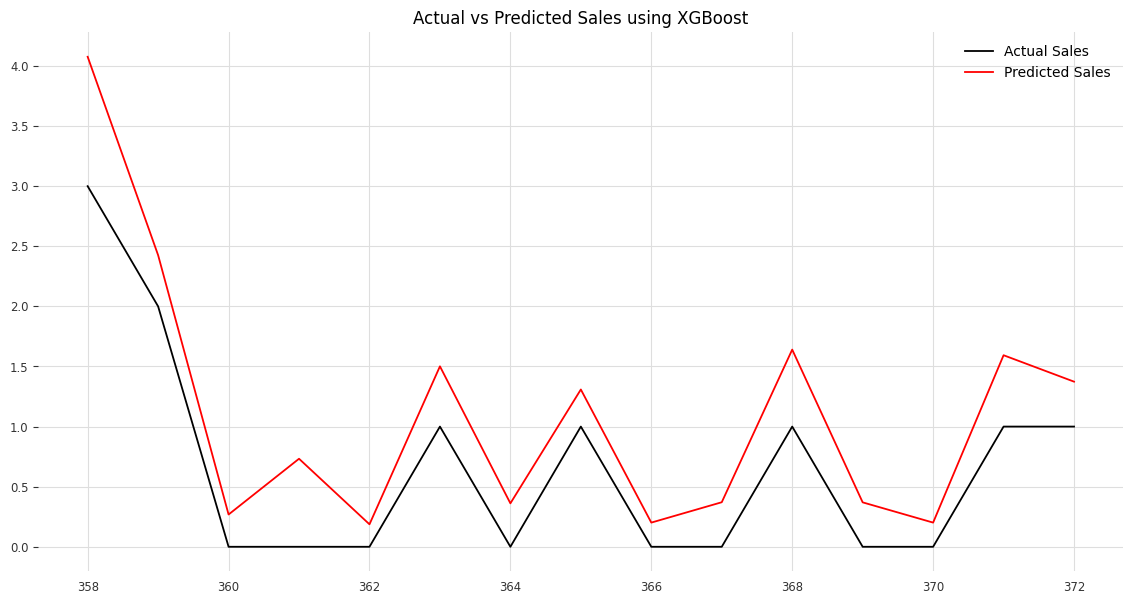

In [374]:
i = 15 # number of days to plot
plt.figure(figsize=(14, 7))
plt.plot(y_test.index[:i], y_test.values[:i], label='Actual Sales')
plt.plot(y_test.index[:i], y_pred[:i], label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.legend()
plt.show()

### 5. Hyperparameter Tuning

In [375]:
# Initializing the model
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the parameter grid
param_grid = {
    'eta': [0.01, 0.05, 0.1, 0.3], # Extend learning rates
    'max_depth': [ 3, 5, 6, 7, 9], # Wider depth range
    'subsample': [ 0.7, 0.8, 0.9, 1.0], # More subsampling options
    'colsample_bytree': [ 0.7, 0.8, 0.9, 1.0], # More features samplig
    'n_estimators': [50, 100, 200, 300, 400], # Wider tree count range
    'min_child_weight': [1, 3, 5, 7], # better Control of overitting
    'gamma': [0, 0.1, 0.2, 0.3, 0.4], # Minimum loss reduction
    'lambda': [0.5, 1, 1.5, 2], # Regularization
    'alpha': [0, 0.1, 0.5, 1] # Regularization
}

# Time series split for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Randomized search with cross-validation
random_search = RandomizedSearchCV(estimator=xgboost_model,
                                   param_distributions=param_grid,
                                   cv=tscv,
                                   n_iter=10,
                                   scoring='neg_mean_squared_error' # this is the MSE metric
                                  )

# Fit the model and search for the best hyperparameters
random_search.fit(X_train, y_train)

# Get best hyperparameters
best_params = random_search.best_params_
print("Best Parameters for XGBoost:", best_params)

Best Parameters for XGBoost: {'subsample': 0.7, 'n_estimators': 50, 'min_child_weight': 7, 'max_depth': 5, 'lambda': 2, 'gamma': 0.3, 'eta': 0.3, 'colsample_bytree': 0.7, 'alpha': 0.5}


### 6. Train Model again with Best Estimators

In [376]:
best_model = random_search.best_estimator_

In [377]:
# Make predictions on the test set
y_pred_1 = best_model.predict(X_test)

In [378]:
def forecast_metrics(y_true, y_pred):
    #converts input data into flattened NumPy arrays
    y_true = np.asarray(y_true, dtype=float).flatten()
    y_pred = np.asarray(y_pred, dtype=float).flatten()

    # basic errors
    errors       = y_true - y_pred
    abs_errors   = np.abs(errors)
    pct_errors   = abs_errors / np.where(y_true == 0, np.nan, y_true)   # avoid ÷0

    # core statistics
    mae   = abs_errors.mean()
    bias  = errors.mean()
    rmse  = np.sqrt((errors ** 2).mean())

    # MAD of the ACTUAL series (dispersion of demand itself)
    mad   = np.abs(y_true - y_true.mean()).mean()

    # Relative MAD = MAE divided by MAD  (how big the forecast error is vs. “typical” variation)
    rmad  = mae / mad if mad else np.nan

    # Mean Absolute Percentage Error
    mape  = np.nanmean(pct_errors) * 100   # expressed in %

    return {
        "MAE" : mae,
        "Bias": bias,
        "MAD" : mad,
        "rMAD": rmad,
        "MAPE": mape,
        "RMSE": rmse
    }


metrics = forecast_metrics(y_test, y_pred_1)
for k, v in metrics.items():
    print(f"{k}: {v:,.2f}")

MAE: 1.15
Bias: -0.30
MAD: 5.29
rMAD: 0.22
MAPE: 39.31
RMSE: 4.79


The tuning was partially successful, but the trade-off depends on priority—choose the tuned model for better typical accuracy or the original model for better outlier handling.


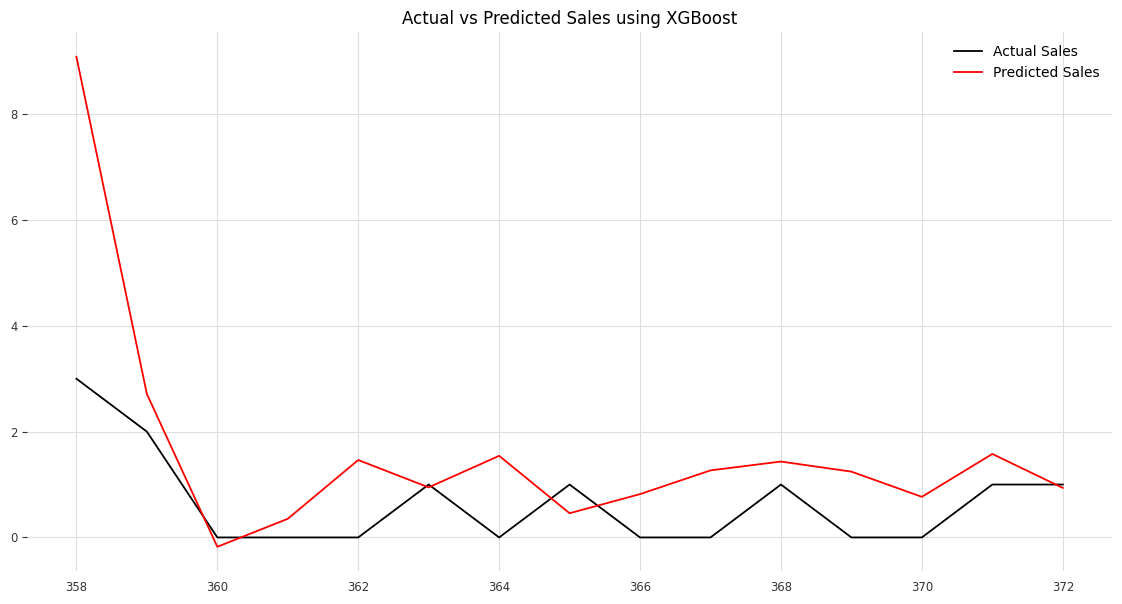

In [379]:
i = 15 # number of days to plot
plt.figure(figsize=(14, 7))
plt.plot(y_test.index[:i], y_test.values[:i], label='Actual Sales')
plt.plot(y_test.index[:i], y_pred_1[:i], label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.legend()
plt.show()

### 7. Save Model as pickel file

In [380]:
# define path where model is going to save
pickle_path = '/Users/lukasfichtner/Documents/VS Code Workspace/favorita-grocery-sales-forecasting/best_model.pkl'

In [381]:
# saving best model
with open(pickle_path, 'wb') as f:
    pickle.dump({'X_train': X_train, 'X_test': X_test, 'best_model': best_model}, f)

print(f"Model saved as pickle file at: {pickle_path}")

Model saved as pickle file at: /Users/lukasfichtner/Documents/VS Code Workspace/favorita-grocery-sales-forecasting/best_model.pkl


## 5. Additional TimeSeries Analysis Models

### 1.Time Series Visualization

In [382]:
# Group by date and aggregate sales for each day
daily_sales = df_train.groupby('date')['unit_sales'].sum().reset_index()

### 2. Plot Time Series


=== TIME SERIES VISUALIZATION ===


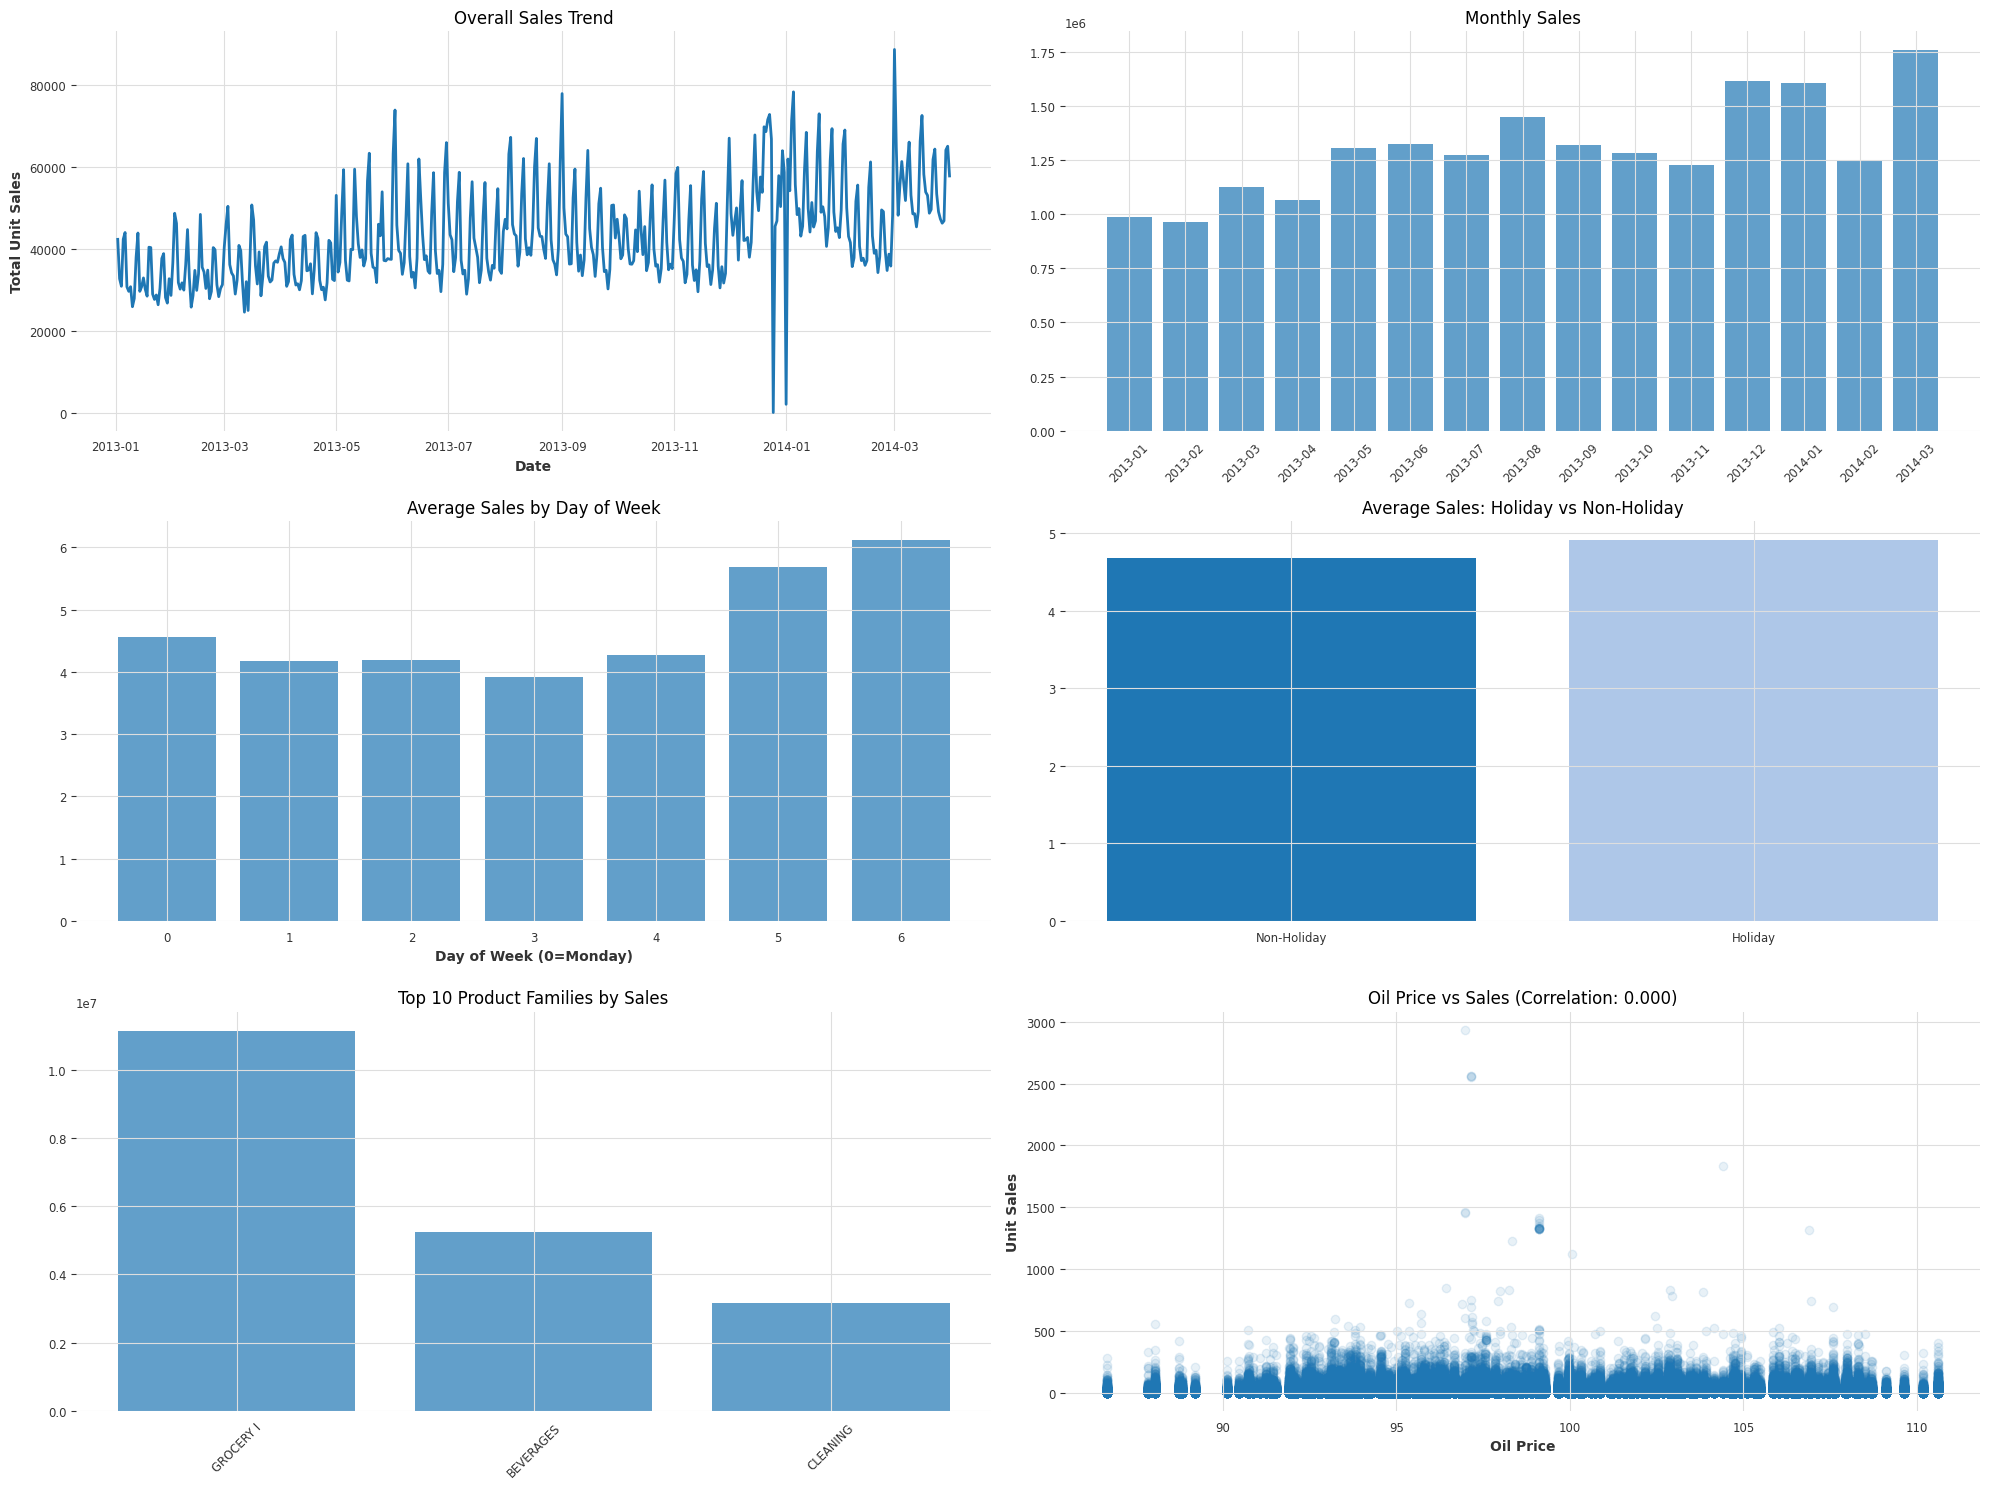

In [383]:
def plot_time_series(df):
    print("\n=== TIME SERIES VISUALIZATION ===")
    fig, axes = plt.subplots(3, 2, figsize=(20, 15))
    
    # Set blue color for all plots
    blue_color = '#1f77b4'  # Default matplotlib blue
    light_blue ='#aec7e8'  # Lighter blue for variety
    
    # Overall sales trend
    axes[0,0].plot(daily_sales['date'], daily_sales['unit_sales'], color=blue_color, linewidth=2)
    axes[0,0].set_title('Overall Sales Trend')
    axes[0,0].set_xlabel('Date')
    axes[0,0].set_ylabel('Total Unit Sales')
    
    # Monthly sales pattern
    monthly_sales = df.groupby(['year', 'month'])['unit_sales'].sum().reset_index()
    monthly_sales['year_month'] = monthly_sales['year'].astype(str) + '-' + monthly_sales['month'].astype(str).str.zfill(2)
    axes[0,1].bar(monthly_sales['year_month'], monthly_sales['unit_sales'], color=blue_color, alpha=0.7)
    axes[0,1].set_title('Monthly Sales')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # Day of week pattern
    dow_sales = df.groupby('day_of_week')['unit_sales'].mean().reset_index()
    axes[1,0].bar(dow_sales['day_of_week'], dow_sales['unit_sales'], color=blue_color, alpha=0.7)
    axes[1,0].set_title('Average Sales by Day of Week')
    axes[1,0].set_xlabel('Day of Week (0=Monday)')
    
    # Holiday vs non-holiday sales
    holiday_sales = df.groupby('is_holiday')['unit_sales'].mean().reset_index()
    axes[1,1].bar(['Non-Holiday', 'Holiday'], holiday_sales['unit_sales'], color=[blue_color, light_blue])
    axes[1,1].set_title('Average Sales: Holiday vs Non-Holiday')
    
    # Sales by family (top 10)
    family_sales = df.groupby('family')['unit_sales'].sum().sort_values(ascending=False).head(10)
    axes[2,0].bar(family_sales.index, family_sales.values, color=blue_color, alpha=0.7)
    axes[2,0].set_title('Top 10 Product Families by Sales')
    axes[2,0].tick_params(axis='x', rotation=45)
    
    # Oil price vs sales correlation
    oil_corr = df[['unit_sales', 'dcoilwtico']].corr().iloc[0,1]
    axes[2,1].scatter(df['dcoilwtico'], df['unit_sales'], alpha=0.1, color=blue_color)
    axes[2,1].set_title(f'Oil Price vs Sales (Correlation: {oil_corr:.3f})')
    axes[2,1].set_xlabel('Oil Price')
    axes[2,1].set_ylabel('Unit Sales')
    
    plt.tight_layout()
    plt.show()

plot_time_series(df_train)

### 3. Time Series Decomposition and Stationarity


=== TIME SERIES DECOMPOSITION ===


/var/folders/18/sn83f4h148vgxw6xg2nvxl7r0000gn/T/ipykernel_2686/3109925569.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.resample('D').mean().fillna(method='ffill')


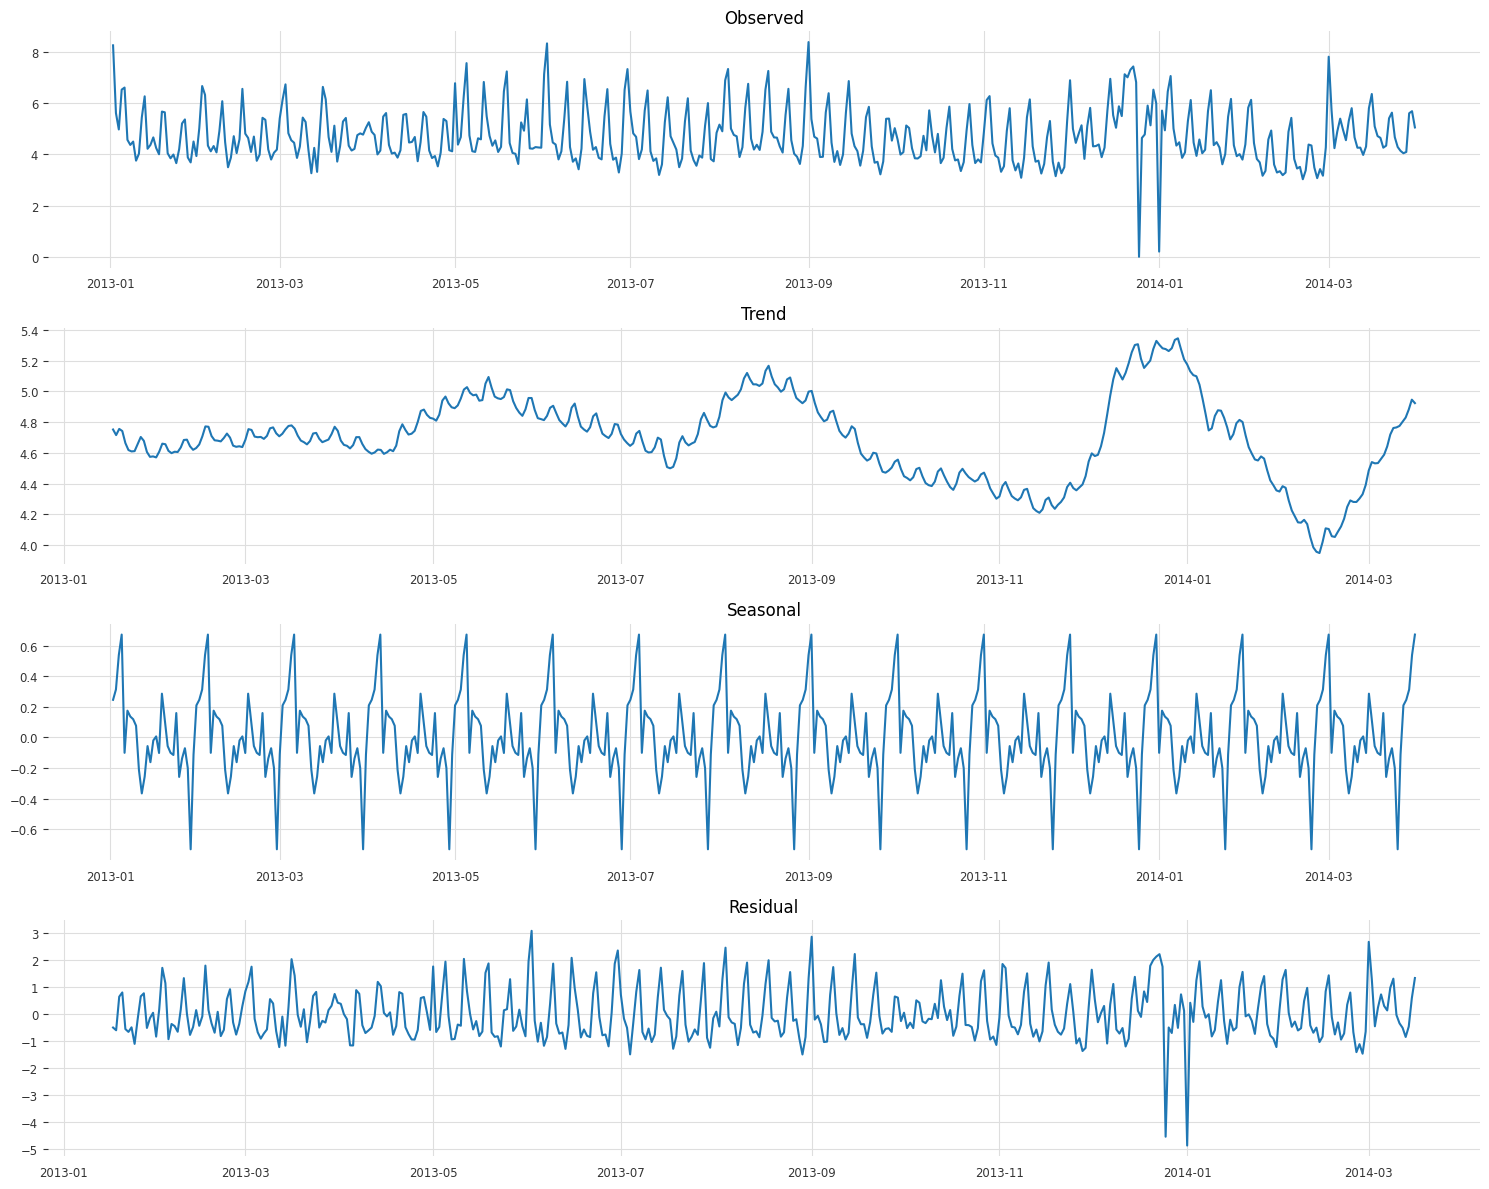

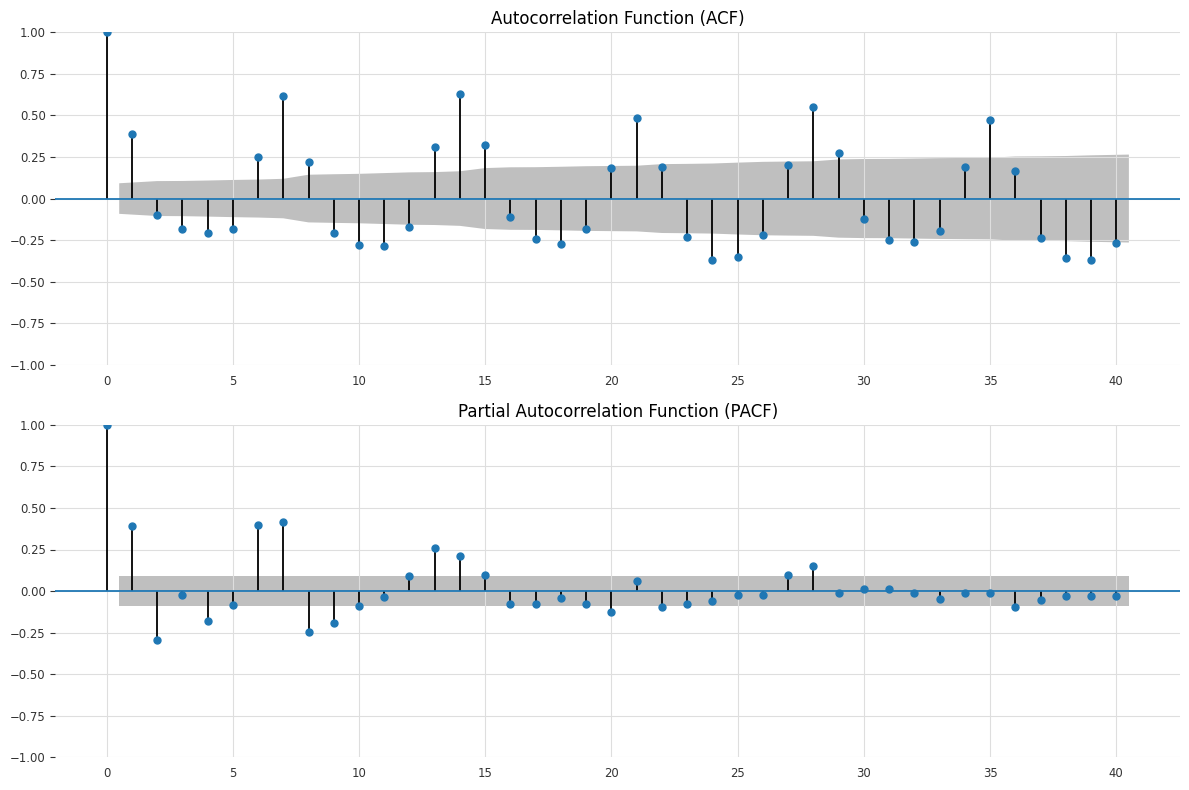

ADF Statistic: -3.582
p-value: 0.006
Critical Values:
   1%: -3.445
   5%: -2.868
   10%: -2.570


In [384]:
def decompose_time_series(df, period=30):
    print(f"\n=== TIME SERIES DECOMPOSITION ===")
    
    # Define blue colors
    blue_color = '#1f77b4'  # Default matplotlib blue
    light_blue = '#aec7e8'  # Lighter blue for variety
    
    df = df.set_index('date')['unit_sales']
    
    # Resample to daily frequency
    df = df.resample('D').mean().fillna(method='ffill')
    
    # Decompose time series
    decomposition = seasonal_decompose(df, period=period, model='additive')
    
    fig, axes = plt.subplots(4, 1, figsize=(15, 12))
    
    # Observed component
    axes[0].plot(decomposition.observed, color=blue_color, linewidth=1.5)
    axes[0].set_title('Observed')
    
    # Trend component
    axes[1].plot(decomposition.trend, color=blue_color, linewidth=1.5)
    axes[1].set_title('Trend')
    
    # Seasonal component
    axes[2].plot(decomposition.seasonal, color=blue_color, linewidth=1.5)
    axes[2].set_title('Seasonal')
    
    # Residual component
    axes[3].plot(decomposition.resid, color=blue_color, linewidth=1.5)
    axes[3].set_title('Residual')
    
    plt.tight_layout()
    plt.show()
    
    # ACF and PACF plots for ARIMA parameter selection
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    # ACF plot with blue color
    plot_acf(df.dropna(), ax=axes[0], lags=40, color=blue_color)
    axes[0].set_title('Autocorrelation Function (ACF)')
    
    # PACF plot with blue color
    plot_pacf(df.dropna(), ax=axes[1], lags=40, color=blue_color)
    axes[1].set_title('Partial Autocorrelation Function (PACF)')
    
    plt.tight_layout()
    plt.show()
    
    # Stationarity test
    result = adfuller(df.dropna())
    print(f'ADF Statistic: {result[0]:.3f}')
    print(f'p-value: {result[1]:.3f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.3f}')

decompose_time_series(df_train)

Based on the Augmented Dickey-Fuller (ADF) test results, the time series is stationary, as the ADF statistic (-3.582) is lower than all critical values (1%, 5%, and 10%) and the p-value (0.006) is well below the 0.05 significance threshold. This confirms that the data does not have a unit root and is suitable for ARIMA modeling without further differencing

The Series has:
 - Overall, the data reflects a combination of a rising trend, seasonal effects, and random noise, with a significant anomaly around early 2014.
 - Observed: The overall data shows significant fluctuations over time, with a noticeable spike around early 2014
 - Trend: There is a general upward trend from mid-2013 to early 2014, followed by a decline and subsequent fluctuations, indicating varying long-term patterns
 - Seasonal: The data exhibits a clear seasonal pattern with regular peaks and troughs approximately every few months, suggesting recurring cycles
 - Residual: The residuals show random fluctuations around zero, indicating that the model captures the trend and seasonal components well, with no obvious systematic errors

ACF:
 - There is a significant spike at lag 0
 - Suggests a strong autocorrelation at the first lag, with little to no significant autocorrelation beyond that

PACF:
 - There is a significant spike at lag 0
 - Significant spike at lag 1, then quickly drops to near zero
 - This suggests that after accounting for the effects of previous lags, there is little to no partial autocorrelation beyond lag 1


### 4. ARIMA Modeling

In [385]:
# Group by date and aggregate sales for each day
series = df_train.groupby('date')['unit_sales'].sum().reset_index()
series['date'] = pd.to_datetime(series['date'])
series = series.set_index('date').sort_index()
series = series['unit_sales']

In [386]:
# Train-Test-Split
split_date = '2014-01-01'

train = series[series.index < split_date]
test = series[series.index >= split_date]

In [387]:
# Initialize ARIMA model with (p, d, q) parameters
arima_model = ARIMA(train, order=(1,1,1))

# Fit the ARIMA model on the training data
arima_model_fit = arima_model.fit()

print(arima_model_fit.summary())

# Forecast the next values (the same length as the test set)
arima_forecast = arima_model_fit.forecast(steps=len(test))
arima_forecast.index = test.index  # align forecast with test dates

                               SARIMAX Results                                
Dep. Variable:             unit_sales   No. Observations:                  364
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3815.231
Date:                Thu, 28 Aug 2025   AIC                           7636.461
Time:                        14:55:03   BIC                           7648.145
Sample:                    01-02-2013   HQIC                          7641.105
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4180      0.059      7.111      0.000       0.303       0.533
ma.L1         -0.9635      0.017    -56.816      0.000      -0.997      -0.930
sigma2      9.898e+07   4.23e-11   2.34e+18      0.0

/Users/lukasfichtner/Documents/VS Code Workspace/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/lukasfichtner/Documents/VS Code Workspace/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/lukasfichtner/Documents/VS Code Workspace/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


R2 score: -0.05
Mean Absolute Error: 8908.83
AIC: 7636.46


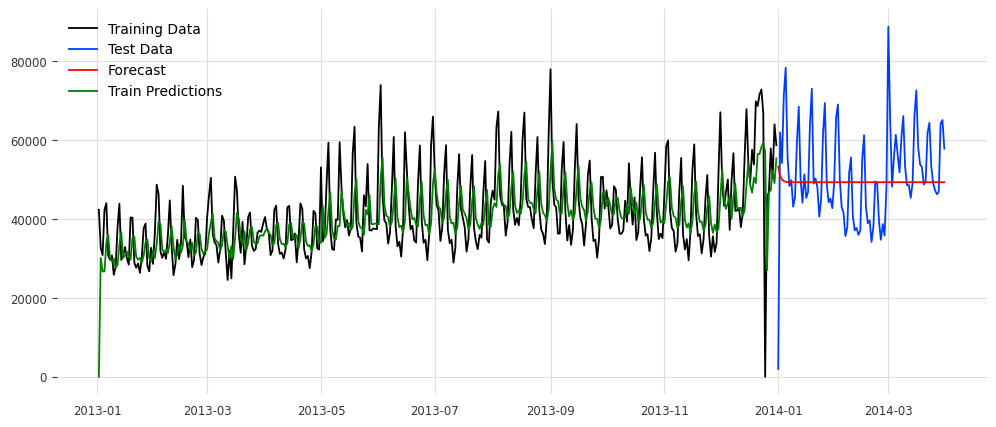

(date
 2014-01-01    53238.044673
 2014-01-02    50957.493984
 2014-01-03    50004.239947
 2014-01-04    49605.786510
 2014-01-05    49439.235795
                   ...     
 2014-03-27    49319.620379
 2014-03-28    49319.620379
 2014-03-29    49319.620379
 2014-03-30    49319.620379
 2014-03-31    49319.620379
 Name: predicted_mean, Length: 90, dtype: float64,
 -0.048640660867583785,
 8908.831933097978)

In [388]:
#Evaluates a fitted ARIMA model against a given test set

def model_evaluation(fit_result, train, test, exog=None):
  
    # In-sample predictions
    train_predictions = fit_result.fittedvalues

    # Forecast future values
    if exog is not None:
        forecast = fit_result.get_forecast(steps=len(test), exog=test[exog])
        test_predictions = forecast.predicted_mean
    else:
        test_predictions = fit_result.forecast(steps=len(test))
    
    # Align forecast index with test index
    test_predictions.index = test.index

    # Evaluation metrics
    mae = mean_absolute_error(test, test_predictions)
    r2 = r2_score(test, test_predictions)

    print(f'R2 score: {r2:1.2f}')
    print(f'Mean Absolute Error: {mae:.2f}')
    print(f'AIC: {fit_result.aic:.2f}')

    # Plot
    fig, ax = plt.subplots(figsize=(12,5))
    ax.plot(train, label='Training Data')
    ax.plot(test, label='Test Data')
    ax.plot(test_predictions, label='Forecast', color='red')
    ax.plot(train_predictions, label='Train Predictions', color='green')
    plt.legend()
    plt.show()

    return test_predictions, r2, mae

model_evaluation(arima_model_fit, train, test, exog=None)

 - R² Score: -0.05: A negative R² score indicates that the model performs worse than a simple mean prediction.

 - MAE: 8908.83: This high MAE value indicates that, on average, the model's predictions deviate by approximately 8908.83 units from the actual values, pointing to significant prediction errors. 
 
 - AIC: 7636.46: The Akaike Information Criterion value is relatively high, suggesting that the model may not be optimally parameterized.

Overall, these metrics suggest that the current ARima model is nit effectively modeling the data.  